In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [100]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [35]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [37]:
def get_images_dataset(train_images_path_str):
    def _process_path(file_path):
        def __decode_img(img):
            # convert the compressed string to a 3D uint8 tensor
            img = tf.image.decode_jpeg(img, channels=3) # XXX: Working only with jpg images.
            # Use `convert_image_dtype` to convert to floats in the [0,1] range.
            img = tf.image.convert_image_dtype(img, tf.float32)
            # resize the image to the desired size.
            return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = __decode_img(img)
        return img

    list_ds = tf.data.Dataset.list_files(train_images_path_str)
    images_ds = list_ds.map(_process_path, num_parallel_calls=AUTOTUNE)
    return images_ds


In [242]:
def apply_augmentations(dataset, augmentation_params):
    def flip(x):
        """Flip augmentation

        Args:
            x: Image to flip

        Returns:
            Augmented image
        """
        x = tf.image.random_flip_left_right(x)
        x = tf.image.random_flip_up_down(x)

        return x

    def color(x):
        """Color augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """
        x = tf.image.random_hue(x, 0.08)
        x = tf.image.random_saturation(x, 0.6, 1.6)
        x = tf.image.random_brightness(x, 0.05)
        x = tf.image.random_contrast(x, 0.7, 1.3)
        return x

    def rotate(x):
        """Rotation augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """

        return tf.image.rot90(x, tf.random.uniform([], minval=0, maxval=4, dtype=tf.dtypes.int32))

    def zoom(x):
        """Zoom augmentation

        Args:
            x: Image

        Returns:
            Augmented image
        """

        # Generate 20 crop settings, ranging from a 1% to 20% crop.
        scales = list(np.arange(0.8, 1.0, 0.01))
        boxes = np.zeros((len(scales), 4))

        for i, scale in enumerate(scales):
            x1 = y1 = 0.5 - (0.5 * scale)
            x2 = y2 = 0.5 + (0.5 * scale)
            boxes[i] = [x1, y1, x2, y2]

        def random_crop(img):
            # Create different crops for an image
            crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMG_HEIGHT, IMG_WIDTH))
            # Return a random croptf.random.uniform([], 0, 1)
            return crops[tf.random.uniform([], minval=0, maxval=len(scales), dtype=tf.dtypes.int32)]

        # Only apply cropping 50% of the time
        choice = tf.random.uniform(shape=[], minval=0., maxval=1)
        return tf.cond(choice < 0.5, lambda: random_crop(x), lambda: x)

    # Apply the augmentations provided.
    supported_agumentations = {
        "flip": flip,
        "color": color,
        "zoom": zoom,
        "rotate": rotate,
    }

    prob = augmentation_params.pop("prob", 0.75)
    for cur_func_name, cur_params in augmentation_params.items():
        # TODO: params are not currently supported.
        choice = tf.random.uniform(shape=[], minval=0., maxval=1)
        dataset = dataset.map(lambda x: tf.cond(choice < prob, lambda: supported_agumentations[cur_func_name](x), lambda: x), num_parallel_calls=4)

    dataset = dataset.map(lambda x: tf.clip_by_value(x, 0, 1))
    return dataset


In [243]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000, augmentation_params=None):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    # Apply augmentations.
    if augmentation_params:
        ds = apply_augmentations(ds, augmentation_params)

    # Batch the dataset.
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds


def show_batch(image_batch):
    plt.figure(figsize=(20, 10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4, 8, n+1)
        plt.imshow(image_batch[n])
        plt.axis('off')


In [244]:
train_images_path_str = "../../data/underwater_background/unsplash/unsplash_underwater_collection/*.jpg"
augmentation_params = {"flip": 1, "color": 1, "zoom": 1, "rotate": 1}

In [245]:
images_ds = get_images_dataset(train_images_path_str)

In [246]:
train_ds = prepare_for_training(images_ds, cache=True, shuffle_buffer_size=1000, augmentation_params=augmentation_params)

In [261]:
image_batch = next(iter(train_ds))

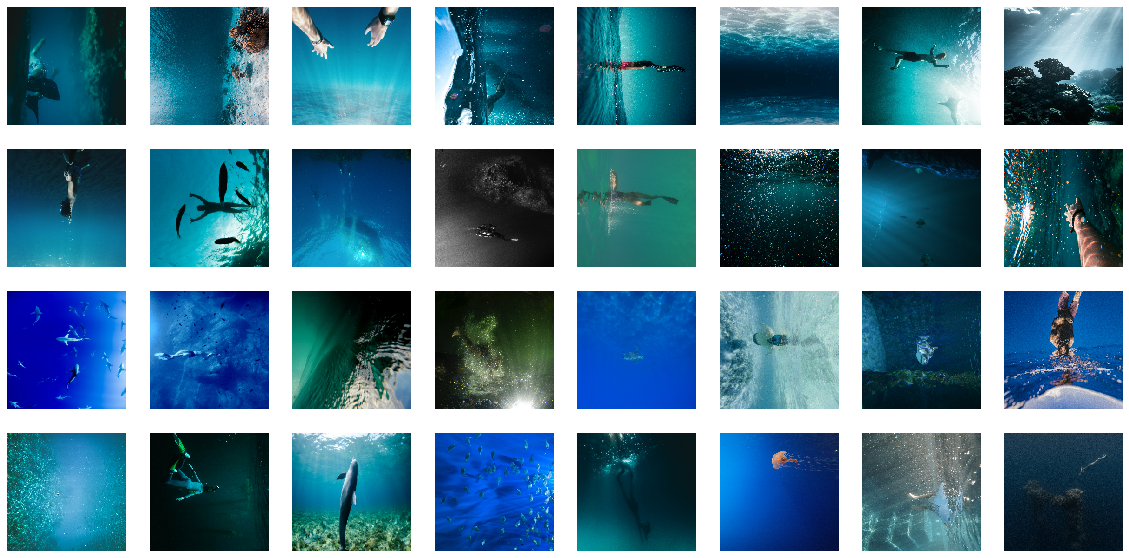

In [262]:
show_batch(image_batch)